<a href="https://colab.research.google.com/github/123RASIKA/text-summarization-and-sentiment-analysis/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Summarizer using NLP and Sentiment Analysis using Deep Neural Network



##TEXT SUMMARIZER

###Setup

In [ ]:
import bs4 as bs
import urllib.request
import re
import nltk
import heapq
import numpy as np
import keras

nltk.download('punkt')
nltk.download('stopwords')


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

###Getting the Data

In [ ]:
#getting the data
source=urllib.request.urlopen('https://en.wikipedia.org/wiki/Global_warming').read()
soup=bs.BeautifulSoup(source,'lxml') #lxml is a parser used by bs for parsing

In [ ]:
text=""
for paragraph in soup.find_all('p'): #p stands for paragraph tag in html
    text+=paragraph.text #paragraph has various properties in bs to fetch text,.text is used


###Preprocessing the text

In [ ]:
#preprocessing the text
text=re.sub(r'\[[0-9]*\]',' ',text) #to replace [][] text with space
text=re.sub(r'\s+',' ',text)
#clean text is used only for creating histogram and summary is formed fron the text only
clean_text=text.lower()#convert it into lower case
clean_text=re.sub(r'\W',' ',clean_text)# removing non word characters
clean_text=re.sub(r'\d',' ',clean_text)
clean_text=re.sub(r'\s+',' ',clean_text)#extra space

###Tokenization and Building Histogram

In [ ]:
#tokenization
sentences=nltk.sent_tokenize(text)
stop_words=nltk.corpus.stopwords.words('english')

#building the histogram
word2count={}
for word in nltk.word_tokenize(clean_text):
    if word not in stop_words:
        if word not in word2count.keys():
            word2count[word]=1
        else:
            word2count[word]+=1

#weighted histogram
for key in word2count.keys():
    word2count[key]=word2count[key]/max(word2count.values())

###Creating Summary

In [ ]:
#calculating the sentence scores

sent2score={}
for sentence in sentences:
    for word in nltk.word_tokenize(sentence.lower()):
        if word in word2count.keys():
            if len(sentence.split(' '))<25: #no of words less than 30
                if sentence not in sent2score.keys():
                    sent2score[sentence]=word2count[word]
                else:
                    sent2score[sentence]+=word2count[word]

#selecting N  sentences

best_sentences=heapq.nlargest(5,sent2score,key=sent2score.get)
sentence=" ".join(best_sentences)


##SENTIMENT ANALYSIS

Sentiment Ananlysis is built by training a [Basic Neural Network] and [recurrent neural network-LSTM] on the IMDB large movie review dataset.

###Setup

In [ ]:
!pip install tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

     |████████████████████████████████| 525.1MB 27kB/s 
     |████████████████████████████████| 2.9MB 48.8MB/s 
     |████████████████████████████████| 460kB 47.8MB/s 


###Importing Packages

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

###Setup Input Pipeline

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using TFDS.

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteYAXXU3/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteYAXXU3/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteYAXXU3/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
encoder = info.features['text'].encoder

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [ ]:
sample_string = 'I am very good'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [12, 258, 67, 248]
The original string: "I am very good"


In [ ]:
assert original_string == sample_string

In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

12 ----> I 
258 ----> am 
67 ----> very 
248 ----> good


###Prepare the Data for Training

Next create batches of these encoded strings. Use the padded_batch method to zero-pad the sequences to the length of the longest string in the batch.



In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

In [ ]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

###Create the Model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.
The results of the embedding will be a 2D array. So we need to flatten it
out.
GlobalAveragePooling1D layer is used for flattening the output of embedding layer.
We then feed that into a dense neural network to do the classification.
This model is a basic or simple neural network.



In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 528,065
Trainable params: 528,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7168 - accuracy: 0.5000 - val_loss: 0.7050 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6996 - accuracy: 0.5000 - val_loss: 0.6944 - val_accuracy: 0.4917
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.4917
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.4917
Epoch 5/10
391/391 [==============================] - 4s 11ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.4917
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.4917
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.4917

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 2s 6ms/step - loss: 0.6890 - accuracy: 0.5082
Test Loss: 0.6889519691467285
Test Accuracy: 0.5082399845123291


Recreating the model using RNN-LSTM

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next. The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.



In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 786s 2s/step - loss: 0.6986 - accuracy: 0.5001 - val_loss: 0.6926 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 801s 2s/step - loss: 0.6907 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4917
Epoch 3/10
391/391 [==============================] - 792s 2s/step - loss: 0.6929 - accuracy: 0.5010 - val_loss: 0.6923 - val_accuracy: 0.4948
Epoch 4/10
391/391 [==============================] - 789s 2s/step - loss: 0.6923 - accuracy: 0.5038 - val_loss: 0.6920 - val_accuracy: 0.4958
Epoch 5/10
391/391 [==============================] - 787s 2s/step - loss: 0.6920 - accuracy: 0.5051 - val_loss: 0.6927 - val_accuracy: 0.4938
Epoch 6/10
391/391 [==============================] - 784s 2s/step - loss: 0.6354 - accuracy: 0.6829 - val_loss: 0.5869 - val_accuracy: 0.7974
Epoch 7/10
391/391 [==============================] - 777s 2s/step - loss: 0.5673 - accuracy: 0.8634 - val_loss: 0.5778 - val_accuracy: 0.8141

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 176s 450ms/step - loss: 0.5742 - accuracy: 0.8522
Test Loss: 0.5741996765136719
Test Accuracy: 0.8521599769592285


Since the accuracy of RNN-LSTM model is quite higher than basic neural network. Therefore, we continue to predict the sentiment using RNN-LSTM.

Padding of the input is done by pad_to_size function and sample predict is used for predicting the sentiment of the document.
If the prediction is >= 0.5, it is positive else it is negative.

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  return (predictions)

This shows the final output of our project, First the summary is get printed by Text summarizer then sentiment analyzer prints the sentiment with the prediction value.

##RESULT

###Summary ans Sentiment of doc

In [ ]:
# predict on a sample text with padding

print('---------------------------------------------------')
for sentence in best_sentences:
    print(sentence)
sample_pred_text = (sentence)
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)
if predictions<0.5:
  print('negative')
else:
  print('positive')

---------------------------------------------------
Many arctic animals rely on sea ice, which has been disappearing in a warming Arctic.
The major causes of current climate change are primarily greenhouse gases, and secondarily land use changes, and aerosols and soot.
While aerosols typically limit global warming by reflecting sunlight, black carbon in soot that falls on snow or ice can contribute to global warming.
Global anthropogenic greenhouse gas emissions in 2018 excluding land use change were equivalent to 52 billion tonnes of carbon dioxide.
The long-term effects of global warming include further ice melt, ocean warming, sea level rise, and ocean acidification.
[[0.40312]]
negative


###Graphs

These are the accuracy and loss graphs of basic neural network.

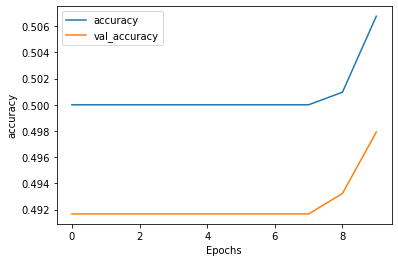

In [ ]:
plot_graphs(history, 'accuracy')

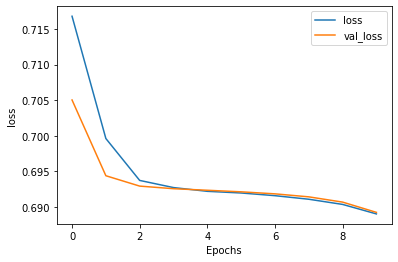

In [ ]:
plot_graphs(history, 'loss')

These are the accuracy and loss graphs for RNN-LSTM Neural Network

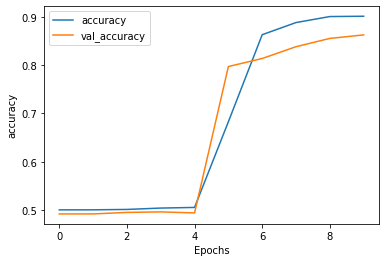

In [ ]:
plot_graphs(history, 'accuracy')

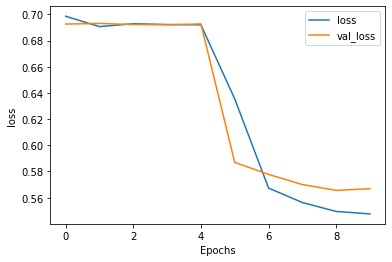

In [ ]:
plot_graphs(history, 'loss')